In [1]:
from a4_utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

def gauss(sigma):
    gauss_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (1 / (math.sqrt(2 * math.pi) * sigma)) * \
            math.exp(-((x ** 2) / (2 * (sigma ** 2))))
        gauss_kernel.append(result_x)
    return np.array(gauss_kernel) / sum(gauss_kernel)

def gaussdx(sigma):
    gaussdx_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (-1 / (math.sqrt(2 * math.pi) * sigma ** 3)) * x * math.exp(-(x ** 2 / (2 * sigma ** 2)))
        gaussdx_kernel.append(result_x)
    return np.array(gaussdx_kernel) / sum(np.abs(gaussdx_kernel))

def compute_derivative(img, sigma):
    G=gauss(sigma).reshape(1,-1)
    GT=G.T
    G=np.flip(G)
    GT=np.flip(GT)

    D=gaussdx(sigma).reshape(1,-1)
    DT=D.T
    D=np.flip(D)
    DT=np.flip(DT)

    img_Gt = cv2.filter2D(img, -1, D)
    deriv_x = cv2.filter2D(img_Gt, -1, GT)
    img_G = cv2.filter2D(img, -1, G)
    deriv_y = cv2.filter2D(img_G, -1, DT)
    return deriv_x, deriv_y

def gaussfilter(img, sigma):
    G = gauss(sigma)
    G = G.reshape(1, -1)
    convolved_img = cv2.filter2D(img, -1, G)
    convolved_img = cv2.filter2D(convolved_img, -1, G.T)
    return convolved_img


def nonmaxima_suppression(det,thresh,box_size):
    h,w=det.shape

    suppressed=np.zeros((h,w))

    for i in range(h):
        for j in range(w):
            if det[i,j]>thresh:
                box=det[i-box_size//2:i+box_size//2+1,j-box_size//2:j+box_size//2+1]
                if box.size>0:
                    max_val=np.max(box)
                else:
                    max_val=0
                if det[i,j] == max_val:
                    suppressed[i,j] = 1
    return suppressed

def hessian_points(I, sigma, threshold):
    Ix, Iy = compute_derivative(I, sigma)
    Ixx,Ixy = compute_derivative(Ix,sigma)
    Iyx,Iyy = compute_derivative(Iy,sigma)

    H=np.zeros((I.shape[0],I.shape[1],2,2))
    H[:,:,0,0]=Ixx
    H[:,:,0,1]=Ixy
    H[:,:,1,0]=Iyx
    H[:,:,1,1]=Iyy

    det= H[:,:,0,0]*H[:,:,1,1]-H[:,:,0,1]*H[:,:,1,0] 
    return det

def harris_points(I, sigma, threshold):
    sigma2 = 1.6 * sigma
    alpha = 0.06
    harris = np.zeros(I.shape)
    C = np.zeros((I.shape[0], I.shape[1], 2, 2))
    Ix,Iy=compute_derivative(I,sigma)

    C[:, :, 0, 0] = gaussfilter(Ix * Ix, sigma2)
    C[:, :, 0, 1] = gaussfilter(Ix * Iy, sigma2)
    C[:, :, 1, 0] = gaussfilter(Ix * Iy, sigma2)
    C[:, :, 1, 1] = gaussfilter(Iy * Iy, sigma2)

    det = C[:,:,0,0]*C[:,:,1,1]-C[:,:,0,1]*C[:,:,1,0]
    trace = C[:, :, 0, 0] + C[:, :, 1, 1]
    harris = det - alpha * trace * trace
    return harris

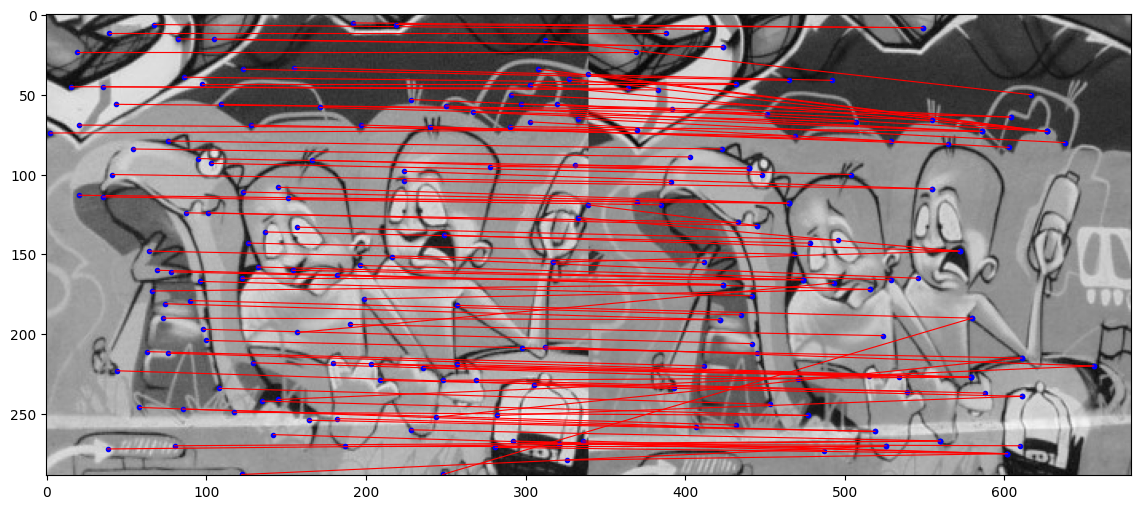

In [2]:
# (a) Use the function simple_descriptors from a4_utils.py to calculate descriptors for a 
# list of feature points. Then, write a function find_correspondences which calculates similarities 
# between all descriptors in two given lists. 

def find_correspondences(list1, list2):
    list_of_pairs=[]
    for i in range(len(list1)):
        descriptor1=list1[i]
        distances=np.zeros(len(list2))
        for j in range(len(list2)):
            descriptor2=list2[j]
            hellinger_distance=np.sqrt(np.sum((np.sqrt(descriptor1)-np.sqrt(descriptor2))**2))
            distances[j]=hellinger_distance
        
        most_similar=np.argmin(distances)
        list_of_pairs.append([i,most_similar])
    return list_of_pairs

graf_a_small_original = cv2.imread("data/graf/graf_a_small.jpg")
graf_a_small_original = cv2.cvtColor(graf_a_small_original, cv2.COLOR_BGR2RGB)
graf_a_small_grayscale = cv2.imread("data/graf/graf_a_small.jpg", cv2.IMREAD_GRAYSCALE) / 255

graf_b_small_original = cv2.imread("data/graf/graf_b_small.jpg")
graf_b_small_original = cv2.cvtColor(graf_b_small_original, cv2.COLOR_BGR2RGB)
graf_b_small_grayscale = cv2.imread("data/graf/graf_b_small.jpg", cv2.IMREAD_GRAYSCALE) / 255

harris_a_small = harris_points(graf_a_small_grayscale, 3, 0.0000001)
harris_b_small = harris_points(graf_b_small_grayscale, 3, 0.0000001)

suppressed_a_small = nonmaxima_suppression(harris_a_small, 0.0000001, 3)
suppressed_b_small = nonmaxima_suppression(harris_b_small, 0.0000001, 3)

x1=np.where(suppressed_a_small==1)[1]
y1=np.where(suppressed_a_small==1)[0]

x2=np.where(suppressed_b_small==1)[1]
y2=np.where(suppressed_b_small==1)[0]

list1 = simple_descriptors(graf_a_small_grayscale, y1, x1)
list2 = simple_descriptors(graf_b_small_grayscale, y2, x2)

pairs = find_correspondences(list1, list2)

points1 = []
for i in range(len(x1)):
    points1.append([x1[i], y1[i]])

points2 = []
for i in range(len(x2)):
    points2.append([x2[i], y2[i]])

most_similar_1 = []
most_similar_2 = []
for a,b in pairs:
    most_similar_1.append(points1[a])
    most_similar_2.append(points2[b])

plt.figure(figsize=(14,8))
display_matches(graf_a_small_grayscale, most_similar_1, graf_b_small_grayscale, most_similar_2)


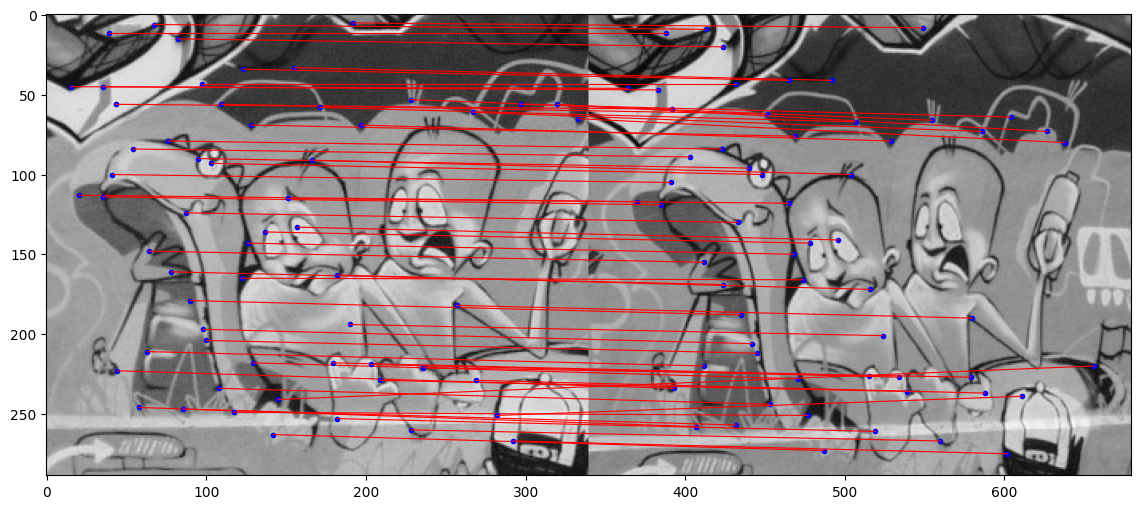

In [3]:
# (b) Implement a simple feature point matching algorithm. Write a function find_matches that is 
# given two images as an input and returns a list of matched feature points from image 1 to image 2. 

def find_matches(I1, I2):
    harris_1 = harris_points(I1, 3, 0.0000001)
    harris_2 = harris_points(I2, 3, 0.0000001)

    suppressed_1 = nonmaxima_suppression(harris_1, 0.0000001, 3)
    suppressed_2 = nonmaxima_suppression(harris_2, 0.0000001, 3)

    x1=np.where(suppressed_1==1)[1]
    y1=np.where(suppressed_1==1)[0]

    x2=np.where(suppressed_2==1)[1]
    y2=np.where(suppressed_2==1)[0]

    list1 = simple_descriptors(I1, y1, x1)
    list2 = simple_descriptors(I2, y2, x2)

    pairs1 = find_correspondences(list1, list2)
    pairs2 = find_correspondences(list2, list1)

    pairs2 = [pair[::-1] for pair in pairs2]
    
    symmteric = []
    for pair in pairs1:
        if pair in pairs2:
            symmteric.append(pair)
    return symmteric

symmetric_pairs = find_matches(graf_a_small_grayscale, graf_b_small_grayscale)

symmetric_most_similar_1 = []
symmetric_most_similar_2 = []
for a,b in symmetric_pairs:
    symmetric_most_similar_1.append(points1[a])
    symmetric_most_similar_2.append(points2[b])

plt.figure(figsize=(14,8))
display_matches(graf_a_small_grayscale, symmetric_most_similar_1, graf_b_small_grayscale, symmetric_most_similar_2)


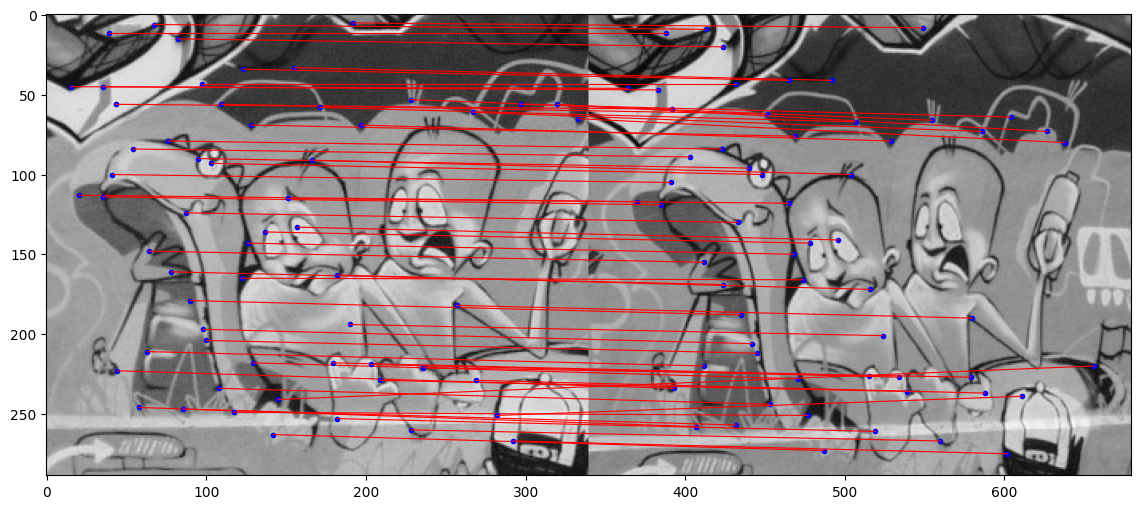

In [4]:
# (c) Incorrect matches can occur when matching descriptors. 
# Suggest and implement a simple method for eliminating at least some of these incorrect matches. 

def find_correspondences_ratio(list1, list2):
    list_of_pairs=[]
    for i in range(len(list1)):
        descriptor1=list1[i]
        distances=np.zeros(len(list2))
        for j in range(len(list2)):
            descriptor2=list2[j]
            hellinger_distance=np.sqrt(np.sum((np.sqrt(descriptor1)-np.sqrt(descriptor2))**2))
            distances[j]=hellinger_distance
        
        smallest_distance=np.min(distances)
        second_smallest_distance=np.sort(distances)[1]
        ratio=smallest_distance/second_smallest_distance
        most_similar=np.argmin(distances)
        if ratio < 0.8:
            list_of_pairs.append([i,most_similar])
    return list_of_pairs

def find_matches_ratio(I1, I2):
    harris_1 = harris_points(I1, 3, 0.0000001)
    harris_2 = harris_points(I2, 3, 0.0000001)

    suppressed_1 = nonmaxima_suppression(harris_1, 0.0000001, 3)
    suppressed_2 = nonmaxima_suppression(harris_2, 0.0000001, 3)

    x1=np.where(suppressed_1==1)[1]
    y1=np.where(suppressed_1==1)[0]

    x2=np.where(suppressed_2==1)[1]
    y2=np.where(suppressed_2==1)[0]

    list1 = simple_descriptors(I1, y1, x1)
    list2 = simple_descriptors(I2, y2, x2)

    pairs1 = find_correspondences_ratio(list1, list2)
    pairs2 = find_correspondences_ratio(list2, list1)

    pairs2 = [pair[::-1] for pair in pairs2]
    
    symmteric = []
    for pair in pairs1:
        if pair in pairs2:
            symmteric.append(pair)
    return symmteric

symmetric_pairs_ratio = find_matches(graf_a_small_grayscale, graf_b_small_grayscale)

symmetric_most_similar_1_ratio = []
symmetric_most_similar_2_ratio = []
for a,b in symmetric_pairs_ratio:
    symmetric_most_similar_1_ratio.append(points1[a])
    symmetric_most_similar_2_ratio.append(points2[b])

plt.figure(figsize=(14,8))
display_matches(graf_a_small_grayscale, symmetric_most_similar_1_ratio, graf_b_small_grayscale, symmetric_most_similar_2_ratio)